In [21]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers   import AveragePooling2D, Conv2D, MaxPooling2D, Dense , Activation , InputLayer , Flatten , Input, BatchNormalization, Dropout, Embedding

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display
import random
from keras.callbacks import *


In [2]:
class config:
    seed = 42
    device = "cuda:0"    
        
    lr = 1e-3
    epochs = 25
    batch_size = 32
    num_workers = 4
    train_5_folds = True

In [3]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

In [4]:
seed_everything(config.seed)

In [5]:
dir_ = Path('final_pjt_brand/')
filepaths = list(dir_.glob(r'**/*'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,final_pjt_brand/ediya/IMG_6399.jpg,ediya
1,final_pjt_brand/twosome/twosome place_525_good...,twosome
2,final_pjt_brand/ediya/IMG_6601.jpg,ediya
3,final_pjt_brand/ediya/ediya_598_good.jpg,ediya
4,final_pjt_brand/twosome/twosome place_929_good...,twosome


In [6]:
spac = df[df['Label'].str.contains('final_pjt_brand')].index

df.drop(spac, inplace=True)

In [7]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 2753

Number of different labels: 4

Labels: ['ediya' 'twosome' 'starbucks' 'hollys']


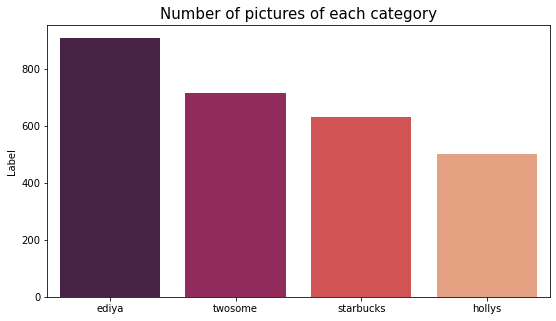

In [8]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [9]:
# Training/test split
train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
# train_df,test_df = train_test_split(df, test_size=0.2,random_state=0)
train_df.shape,test_df.shape

((495, 2), (56, 2))

In [10]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('./final_pjt_brand',
                                                 target_size = (300, 300),
                                                 batch_size = 16,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('./final_pjt_brand',
                                                 target_size = (300, 300),
                                                 batch_size = 16,
                                                 class_mode = 'categorical',subset='validation')

Found 2204 images belonging to 4 classes.
Found 549 images belonging to 4 classes.


In [11]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(448, 448), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        brightness_range=(0.2,0.8),
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        vertical_flip=True,
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(448, 448),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=(0.2,0.8),
        shear_range=0.15,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(448, 448),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [12]:
# train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

Found 446 validated image filenames belonging to 4 classes.
Found 49 validated image filenames belonging to 4 classes.
Found 56 validated image filenames belonging to 4 classes.


In [13]:
# earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
#                               patience=5,         # 10회 Epoch동안 개선되지 않는다면 종료
#                              )

In [14]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D

In [15]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(448, 448, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input
    
    x = tf.keras.layers.GlobalAveragePooling2D()
    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

#     x = tf.keras.layers.Flatten()(x)
#     x = tf.keras.layers.Dropout(0.5)(x)
    
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Found 446 validated image filenames belonging to 4 classes.
Found 49 validated image filenames belonging to 4 classes.
Found 56 validated image filenames belonging to 4 classes.




In [25]:
# Source code: https://github.com/opconty/keras-shufflenetV2/blob/master/shufflenetv2.py



from keras.utils.vis_utils import plot_model
from keras_applications.imagenet_utils import _obtain_input_shape
# from keras.engine.topology import get_source_inputs
from keras.utils.layer_utils import get_source_inputs
from keras.layers import Input, Conv2D, MaxPool2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dense
from keras.models import Model
import keras.backend as K



import os
from keras import backend as K
from keras.models import Model
# from keras.engine.topology import get_source_inputs
from keras.layers import Activation, Add, Concatenate, Conv2D, GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D,Input, Dense
from keras.layers import MaxPool2D,AveragePooling2D, BatchNormalization, Lambda, DepthwiseConv2D
import numpy as np


def channel_split(x, name=''):
    # equipartition
    in_channles = x.shape.as_list()[-1]
    ip = in_channles // 2
    c_hat = Lambda(lambda z: z[:, :, :, 0:ip], name='%s/sp%d_slice' % (name, 0))(x)
    c = Lambda(lambda z: z[:, :, :, ip:], name='%s/sp%d_slice' % (name, 1))(x)
    return c_hat, c

def channel_shuffle(x):
    height, width, channels = x.shape.as_list()[1:]
    channels_per_split = channels // 2
    x = K.reshape(x, [-1, height, width, 2, channels_per_split])
    x = K.permute_dimensions(x, (0,1,2,4,3))
    x = K.reshape(x, [-1, height, width, channels])
    return x


def shuffle_unit(inputs, out_channels, bottleneck_ratio,strides=2,stage=1,block=1):
    if K.image_data_format() == 'channels_last':
        bn_axis = -1
    else:
        raise ValueError('Only channels last supported')

    prefix = 'stage{}/block{}'.format(stage, block)
    bottleneck_channels = int(out_channels * bottleneck_ratio)
    if strides < 2:
        c_hat, c = channel_split(inputs, '{}/spl'.format(prefix))
        inputs = c

    x = Conv2D(bottleneck_channels, kernel_size=(1,1), strides=1, padding='same', name='{}/1x1conv_1'.format(prefix))(inputs)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_1'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_1'.format(prefix))(x)
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', name='{}/3x3dwconv'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv'.format(prefix))(x)
    x = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1conv_2'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_2'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_2'.format(prefix))(x)

    if strides < 2:
        ret = Concatenate(axis=bn_axis, name='{}/concat_1'.format(prefix))([x, c_hat])
    else:
        s2 = DepthwiseConv2D(kernel_size=3, strides=2, padding='same', name='{}/3x3dwconv_2'.format(prefix))(inputs)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv_2'.format(prefix))(s2)
        s2 = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1_conv_3'.format(prefix))(s2)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_3'.format(prefix))(s2)
        s2 = Activation('relu', name='{}/relu_1x1conv_3'.format(prefix))(s2)
        ret = Concatenate(axis=bn_axis, name='{}/concat_2'.format(prefix))([x, s2])

    ret = Lambda(channel_shuffle, name='{}/channel_shuffle'.format(prefix))(ret)

    return ret


def block(x, channel_map, bottleneck_ratio, repeat=1, stage=1):
    x = shuffle_unit(x, out_channels=channel_map[stage-1],
                      strides=2,bottleneck_ratio=bottleneck_ratio,stage=stage,block=1)

    for i in range(1, repeat+1):
        x = shuffle_unit(x, out_channels=channel_map[stage-1],strides=1,
                          bottleneck_ratio=bottleneck_ratio,stage=stage, block=(1+i))

    return x


def ShuffleNetV2(include_top=True,
                 input_tensor=None,
                 scale_factor=1.0,
                 pooling='max',
                 input_shape=(448,448,3),
                 load_model=None,
                 num_shuffle_units=[3,7,3],
                 bottleneck_ratio=1,
                 classes=4):
    if K.backend() != 'tensorflow':
        raise RuntimeError('Only tensorflow supported for now')
    name = 'ShuffleNetV2_{}_{}_{}'.format(scale_factor, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))
    input_shape = _obtain_input_shape(input_shape, default_size=224, min_size=28, require_flatten=include_top,
                                      data_format=K.image_data_format())
    out_dim_stage_two = {0.5:48, 1:116, 1.5:176, 2:244}

    if pooling not in ['max', 'avg']:
        raise ValueError('Invalid value for pooling')
    if not (float(scale_factor)*4).is_integer():
        raise ValueError('Invalid value for scale_factor, should be x over 4')
    exp = np.insert(np.arange(len(num_shuffle_units), dtype=np.float32), 0, 0)  # [0., 0., 1., 2.]
    out_channels_in_stage = 2**exp
    out_channels_in_stage *= out_dim_stage_two[bottleneck_ratio]  #  calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage *= scale_factor
    out_channels_in_stage = out_channels_in_stage.astype(int)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # create shufflenet architecture
    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same', use_bias=False, strides=(2, 2),
               activation='relu', name='conv1')(img_input)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='maxpool1')(x)

    # create stages containing shufflenet units beginning at stage 2
    for stage in range(len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = block(x, out_channels_in_stage,
                   repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   stage=stage + 2)

    if bottleneck_ratio < 2:
        k = 1024
    else:
        k = 2048
    x = Conv2D(k, kernel_size=1, padding='same', strides=1, name='1x1conv5_out', activation='relu')(x)

    if pooling == 'avg':
        x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name='global_max_pool')(x)

    if include_top:
        x = Dense(classes, name='fc')(x)
        x = Activation('softmax', name='softmax')(x)

    if input_tensor:
        inputs = get_source_inputs(input_tensor)

    else:
        inputs = img_input

    model = Model(inputs, x, name=name)

    if load_model:
        model.load_weights('', by_name=True)

    return model

In [26]:
# for name, model in models.items():
    
#     # 전이 학습 모델 가져오기
#     m = get_model(model['model'])
#     models[name]['model'] = m
    
#     start = perf_counter()
    
#     # 모델 학습
#     history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
#     # 학습시간과 val_accuracy 저장
#     duration = perf_counter() - start
#     duration = round(duration,2)
#     models[name]['perf'] = duration
#     print(f"{name:20} trained in {duration} sec")
    
#     val_acc = history.history['val_accuracy']
#     models[name]['val_acc'] = [round(v,4) for v in val_acc]

In [27]:
spac = test_df[test_df['Label'].str.contains('final_test_brand')].index
test_df2 = test_df.drop(spac)

In [28]:
test_df2['Label'].unique()

array(['hollys', 'starbucks', 'twosome', 'ediya'], dtype=object)

In [29]:
# # test데이터로 모델 성능 예측
# for name, model in models.items():
    
#     # Predict the label of the test_images
#     pred = models[name]['model'].predict(test_images)
#     pred = np.argmax(pred,axis=1)

#     # Map the label
#     labels = (train_images.class_indices)
#     labels = dict((v,k) for k,v in labels.items())
#     pred = [labels[k] for k in pred]

#     y_test = list(test_df2.Label)
#     acc = accuracy_score(y_test,pred)
#     models[name]['acc'] = round(acc,4)
#     print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# # Create a DataFrame with the results
# models_result = []

# for name, v in models.items():
#     models_result.append([ name, models[name]['val_acc'][-1], 
#                           models[name]['acc'],
#                           models[name]['perf']])
    
# df_results = pd.DataFrame(models_result, 
#                           columns = ['model','val_accuracy','accuracy','Training time (sec)'])
# df_results.sort_values(by='accuracy', ascending=False, inplace=True)
# df_results.reset_index(inplace=True,drop=True)
# df_results

In [30]:
# plt.figure(figsize = (15,5))
# sns.barplot(x = 'model', y = 'accuracy', data = df_results)
# plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
# plt.ylim(0,1)
# plt.xticks(rotation=90)
# plt.show()

In [31]:
# plt.figure(figsize = (15,5))
# sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
# plt.title('Training time for each model in sec', fontsize = 15)
# # plt.ylim(0,20)
# plt.xticks(rotation=90)
# plt.show()


In [32]:
test_images.class_indices

{'ediya': 0, 'hollys': 1, 'starbucks': 2, 'twosome': 3}

In [33]:
model = ShuffleNetV2(include_top=True, input_shape=(448, 448, 3),load_model=None)
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',   
              metrics=['accuracy'])
print(model.summary())

Model: "ShuffleNetV2_1.0_1_373"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 224, 224, 24  648         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 maxpool1 (MaxPooling2D)        (None, 112, 112, 24  0           ['conv1[0][0]']                  
                                )                                            

 stage2/block2/relu_1x1conv_2 (  (None, 56, 56, 116)  0          ['stage2/block2/bn_1x1conv_2[0][0
 Activation)                                                     ]']                              
                                                                                                  
 stage2/block2/spl/sp0_slice (L  (None, 56, 56, 116)  0          ['stage2/block1/channel_shuffle[0
 ambda)                                                          ][0]']                           
                                                                                                  
 stage2/block2/concat_1 (Concat  (None, 56, 56, 232)  0          ['stage2/block2/relu_1x1conv_2[0]
 enate)                                                          [0]',                            
                                                                  'stage2/block2/spl/sp0_slice[0][
                                                                 0]']                             
          

 enate)                                                          [0]',                            
                                                                  'stage2/block4/spl/sp0_slice[0][
                                                                 0]']                             
                                                                                                  
 stage2/block4/channel_shuffle   (None, 56, 56, 232)  0          ['stage2/block4/concat_1[0][0]'] 
 (Lambda)                                                                                         
                                                                                                  
 stage3/block1/1x1conv_1 (Conv2  (None, 56, 56, 232)  54056      ['stage2/block4/channel_shuffle[0
 D)                                                              ][0]']                           
                                                                                                  
 stage3/bl

                                                                                                  
 stage3/block2/concat_1 (Concat  (None, 28, 28, 464)  0          ['stage3/block2/relu_1x1conv_2[0]
 enate)                                                          [0]',                            
                                                                  'stage3/block2/spl/sp0_slice[0][
                                                                 0]']                             
                                                                                                  
 stage3/block2/channel_shuffle   (None, 28, 28, 464)  0          ['stage3/block2/concat_1[0][0]'] 
 (Lambda)                                                                                         
                                                                                                  
 stage3/block3/spl/sp1_slice (L  (None, 28, 28, 232)  0          ['stage3/block2/channel_shuffle[0
 ambda)   

 (Lambda)                                                                                         
                                                                                                  
 stage3/block5/spl/sp1_slice (L  (None, 28, 28, 232)  0          ['stage3/block4/channel_shuffle[0
 ambda)                                                          ][0]']                           
                                                                                                  
 stage3/block5/1x1conv_1 (Conv2  (None, 28, 28, 232)  54056      ['stage3/block5/spl/sp1_slice[0][
 D)                                                              0]']                             
                                                                                                  
 stage3/block5/bn_1x1conv_1 (Ba  (None, 28, 28, 232)  928        ['stage3/block5/1x1conv_1[0][0]']
 tchNormalization)                                                                                
          

                                                                                                  
 stage3/block7/bn_1x1conv_1 (Ba  (None, 28, 28, 232)  928        ['stage3/block7/1x1conv_1[0][0]']
 tchNormalization)                                                                                
                                                                                                  
 stage3/block7/relu_1x1conv_1 (  (None, 28, 28, 232)  0          ['stage3/block7/bn_1x1conv_1[0][0
 Activation)                                                     ]']                              
                                                                                                  
 stage3/block7/3x3dwconv (Depth  (None, 28, 28, 232)  2320       ['stage3/block7/relu_1x1conv_1[0]
 wiseConv2D)                                                     [0]']                            
                                                                                                  
 stage3/bl

 stage4/block1/3x3dwconv_2 (Dep  (None, 14, 14, 464)  4640       ['stage3/block8/channel_shuffle[0
 thwiseConv2D)                                                   ][0]']                           
                                                                                                  
 stage4/block1/bn_3x3dwconv (Ba  (None, 14, 14, 464)  1856       ['stage4/block1/3x3dwconv[0][0]']
 tchNormalization)                                                                                
                                                                                                  
 stage4/block1/bn_3x3dwconv_2 (  (None, 14, 14, 464)  1856       ['stage4/block1/3x3dwconv_2[0][0]
 BatchNormalization)                                             ']                               
                                                                                                  
 stage4/block1/1x1conv_2 (Conv2  (None, 14, 14, 464)  215760     ['stage4/block1/bn_3x3dwconv[0][0
 D)       

 Activation)                                                     ]']                              
                                                                                                  
 stage4/block3/3x3dwconv (Depth  (None, 14, 14, 464)  4640       ['stage4/block3/relu_1x1conv_1[0]
 wiseConv2D)                                                     [0]']                            
                                                                                                  
 stage4/block3/bn_3x3dwconv (Ba  (None, 14, 14, 464)  1856       ['stage4/block3/3x3dwconv[0][0]']
 tchNormalization)                                                                                
                                                                                                  
 stage4/block3/1x1conv_2 (Conv2  (None, 14, 14, 464)  215760     ['stage4/block3/bn_3x3dwconv[0][0
 D)                                                              ]']                              
          

In [34]:
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [35]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

# model = get_model(tf.keras.applications.Xception)
history = model.fit(train_images,validation_data=val_images,
                    epochs=20,callbacks=callbacks_list)


Found 2230 validated image filenames belonging to 4 classes.
Found 247 validated image filenames belonging to 4 classes.
Found 276 validated image filenames belonging to 4 classes.
Epoch 1/20


2022-06-26 16:22:26.834386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.9157 - accuracy: 0.5906

2022-06-26 16:24:57.067504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.20243, saving model to weights-improvement-01-0.20.hdf5
70/70 [==============================] - 169s 2s/step - loss: 1.9157 - accuracy: 0.5906 - val_loss: 1.4278 - val_accuracy: 0.2024
Epoch 2/20
70/70 [==============================] - ETA: 0s - loss: 0.3629 - accuracy: 0.8717
Epoch 2: val_accuracy did not improve from 0.20243
70/70 [==============================] - 160s 2s/step - loss: 0.3629 - accuracy: 0.8717 - val_loss: 1.5063 - val_accuracy: 0.2024
Epoch 3/20
70/70 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9399
Epoch 3: val_accuracy did not improve from 0.20243
70/70 [==============================] - 160s 2s/step - loss: 0.1755 - accuracy: 0.9399 - val_loss: 1.6373 - val_accuracy: 0.2024
Epoch 4/20
70/70 [==============================] - ETA: 0s - loss: 0.0846 - accuracy: 0.9709
Epoch 4: val_accuracy did not improve from 0.20243
70/70 [==============================] - 159s 2s/step - loss: 0.0846 - a

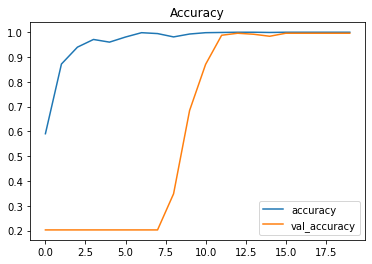

In [36]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

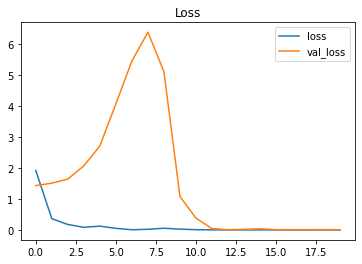

In [37]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [38]:
spac = test_df[test_df['Label'].str.contains('final_pjt_brand')].index
test_df2 = test_df.drop(spac)

test_df2

,Filepath,Label
352,final_pjt_brand/hollys/hollys_good (432).jpg,hollys
1463,final_pjt_brand/hollys/hollys_good (428).jpg,hollys
1025,final_pjt_brand/hollys/hollys_good (381).jpg,hollys
2181,final_pjt_brand/starbucks/starbucks_615_good.jpg,starbucks
2635,final_pjt_brand/twosome/twosome place_659_good...,twosome
...,...,...
2214,final_pjt_brand/starbucks/starbucks_572_good.jpg,starbucks
899,final_pjt_brand/starbucks/starbucks_439_good.jpg,starbucks
1268,final_pjt_brand/twosome/twosome place_847_good...,twosome
1769,final_pjt_brand/twosome/twosome place_514_good...,twosome


In [39]:
test_df

,Filepath,Label
352,final_pjt_brand/hollys/hollys_good (432).jpg,hollys
1463,final_pjt_brand/hollys/hollys_good (428).jpg,hollys
1025,final_pjt_brand/hollys/hollys_good (381).jpg,hollys
2181,final_pjt_brand/starbucks/starbucks_615_good.jpg,starbucks
2635,final_pjt_brand/twosome/twosome place_659_good...,twosome
...,...,...
2214,final_pjt_brand/starbucks/starbucks_572_good.jpg,starbucks
899,final_pjt_brand/starbucks/starbucks_439_good.jpg,starbucks
1268,final_pjt_brand/twosome/twosome place_847_good...,twosome
1769,final_pjt_brand/twosome/twosome place_514_good...,twosome


In [40]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df2.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

2022-06-26 17:15:49.476077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on the test set: 98.91%


In [41]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

       ediya       0.99      0.99      0.99        92
      hollys       1.00      1.00      1.00        57
   starbucks       0.99      0.97      0.98        68
     twosome       0.98      1.00      0.99        59

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



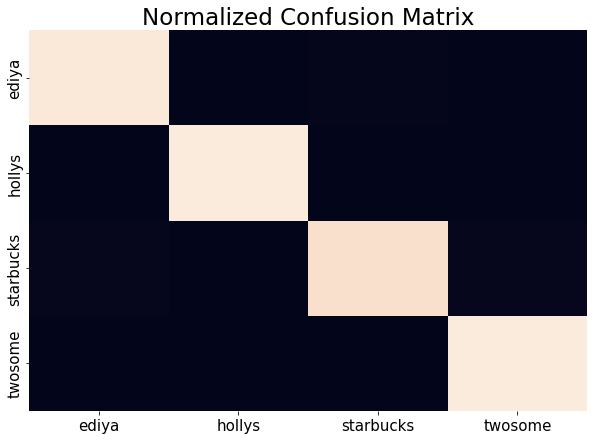

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## 예측률 : 81.55%

### Class prediction = ediya

[[8.1548047e-01 2.7951417e-06 1.7786586e-01 6.6508716e-03]]


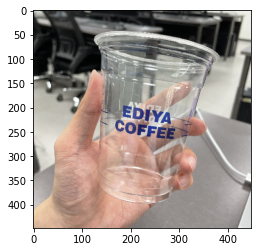

In [37]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
class_dictionary = {'twosome place':3,
                    'hollys':1,
                    'starbucks':2,
                   'ediya':0}
IMAGE_SIZE    = (448, 448)
# number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img('../AI/img/test1.jpg'
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")
    break

print(prediction)

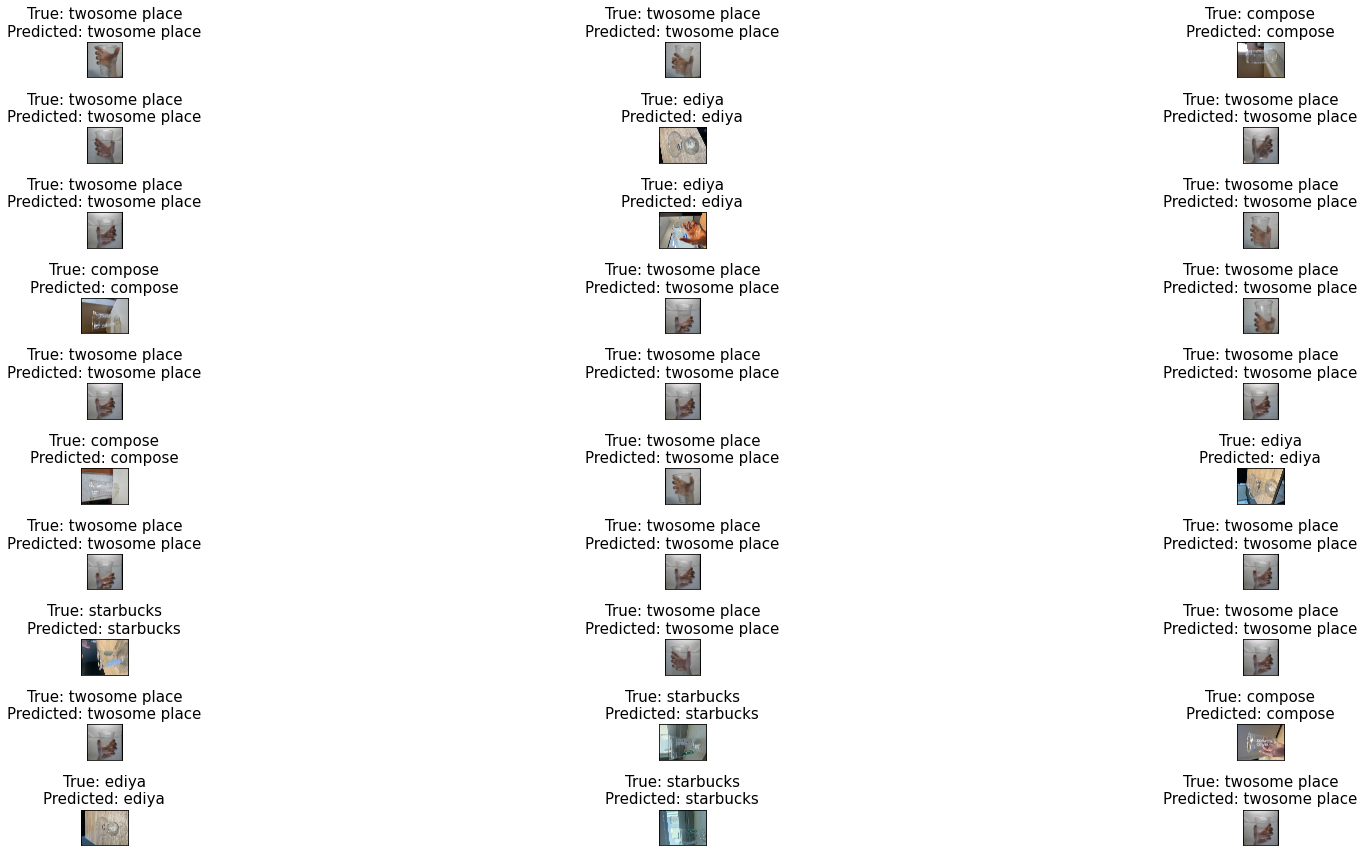

In [31]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(30, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df2.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df2.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 223, 223, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 223, 223, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

 2D)                                                                                              
                                                                                                  
 block4_sepconv1_bn (BatchNorma  (None, 56, 56, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 56, 56, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 56, 56, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
          

                                                                                                  
 block7_sepconv1_act (Activatio  (None, 28, 28, 728)  0          ['add_4[0][0]']                  
 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 28, 28, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_se

 2D)                                                                                              
                                                                                                  
 block9_sepconv3_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 28, 28, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 28, 28, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
          

 block12_sepconv2_bn (BatchNorm  (None, 28, 28, 728)  2912       ['block12_sepconv2[0][0]']       
 alization)                                                                                       
                                                                                                  
 block12_sepconv3_act (Activati  (None, 28, 28, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 28, 28, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 28, 28, 728)  2912       ['block12_sepconv3[0][0]']       
 alization

In [43]:
model.save('brand_shufflenet_adam_epoch20_batch16.h5')

In [47]:
tf.keras.models.save_model(model, './brand_shufflenet_adam_epoch20_batch16_2')

INFO:tensorflow:Assets written to: ./brand_shufflenet_adam_epoch20_batch16_2/assets


INFO:tensorflow:Assets written to: ./brand_shufflenet_adam_epoch20_batch16_2/assets


In [45]:
def representative_dataset():
    for _ in range(100):
      data = np.random.rand(1, 448, 448, 3)
      yield [data.astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_saved_model('./brand_shufflenet_adam_epoch20_batch16')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # or tf.uint8
converter.inference_output_type = tf.uint8  # or tf.uint8
tflite_quant_model = converter.convert()
open("brand_shufflenet_adam_epoch20_batch16.tflite", "wb").write(tflite_quant_model)


2022-06-26 17:16:46.097263: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-06-26 17:16:46.097283: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-06-26 17:16:46.101137: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: ./brand_shufflenet_adam_epoch20_batch16
2022-06-26 17:16:46.122952: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-06-26 17:16:46.122965: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: ./brand_shufflenet_adam_epoch20_batch16
2022-06-26 17:16:46.185833: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-06-26 17:16:46.762856: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: ./brand_shufflenet_adam_epoch20_batch16
2022-06-26 17:16:46.924075: I tensorflow/cc/saved_model/loader.cc:301] 

4458560

In [46]:
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'brand_shufflenet_adam_epoch20_batch16.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)